## Setup

# Tensorflow Road Signs YOLO Debugging Notebook

In [1]:
# Import packages from the Python standard library
import warnings
from pathlib import Path

# Import third-party Python packages
import numpy as np
import imgaug as ia

# Import utils.py file
import utils

# Import training script objects
from train_script import input_image_shape, efficientnet_model, efficientnet_bbox_nms, efficientnet_testing_data, get_predicted_bbox_images

# Create random number generator
rng = np.random.default_rng(54399264723942495723666216079516778448)

2022-03-08 18:13:14.254725: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-08 18:13:14.254893: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
CHECKPOINTS_DIR = Path("checkpoints")
PATCHES_DIR = Path("patches")

MODEL_WEIGHTS = CHECKPOINTS_DIR / "train3-weights.100-0.393.hdf5"

IMAGENET_PATCHES_DIR = PATCHES_DIR / "imagenet_patches"
PAPER_PATCHES_DIR = PATCHES_DIR / "paper_patches"
VIVID_IMAGENET_PATCHES_DIR = PATCHES_DIR / "vivid_imagenet_patches"

In [30]:
efficientnet_model.build((None, input_image_shape[0], input_image_shape[1], input_image_shape[2]))
efficientnet_model.load_weights(str(MODEL_WEIGHTS))
predictions = get_predicted_bbox_images(efficientnet_testing_data, efficientnet_model, input_image_shape, efficientnet_bbox_nms, PAPER_PATCHES_DIR / "Crab Patch.png", 0.2)

In [89]:
pred_image, pred_boxes, pred_scores, pred_labels, pred_num_detections, pred_conf, pred_labels_proba = next(predictions)
patched_pred_image, patched_pred_boxes, patched_pred_scores, patched_pred_labels, patched_pred_num_detections, patched_pred_conf, patched_pred_labels_proba = next(predictions)

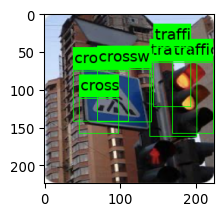

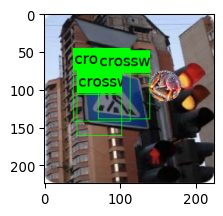

In [90]:

ia.imshow(pred_image)
ia.imshow(patched_pred_image)


In [62]:
patched_pred_conf.numpy()[..., 1] > 0.5

array([[False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False,  True, False, False, False, False],
       [False, False,  True,  True, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False]])

In [63]:
pred_labels_proba.numpy()[3, 3]

array([1.6865247e-09, 1.0000000e+00, 4.1607649e-08, 1.1233733e-09],
      dtype=float32)

In [64]:
patched_pred_labels_proba.numpy()[3, 3]

array([0.0151794 , 0.9758066 , 0.00424595, 0.00476809], dtype=float32)